In [1]:
import pandas as pd
import numpy as np
import os
import pysam
import seaborn as sns
import pyreadr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import scipy
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
import io

import nb_util as nb

In [2]:
fpath = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
df = pd.read_csv(fpath)
df = df.set_index('geneName')
gene_names = df.index.to_list()

raw = df.reset_index(drop=False)

raw = pd.melt(raw, id_vars='geneName')
raw['timepoint'] = raw['variable'].map(nb.tmap)
raw['replicate'] = raw['variable'].map(nb.rmap)
raw['control'] = raw['variable'].map(nb.cmap)
raw['hours'] = raw['timepoint'] * 8

raw.head()

,geneName,variable,value,timepoint,replicate,control,hours
0,A1BG,S1a,12,0,r1c,control,0
1,A1CF,S1a,0,0,r1c,control,0
2,A2M,S1a,0,0,r1c,control,0
3,A2ML1,S1a,0,0,r1c,control,0
4,A3GALT2,S1a,0,0,r1c,control,0


In [3]:
raw_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"
gf = nb.getGeneLengths(raw_path, gene_names)
gf.head()

/tmp/ipykernel_1520143/321717080.py:2: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  gf = nb.getGeneLengths(raw_path, gene_names)


,gene_name,Length
0,A1BG,8315
1,A1CF,86267
2,A2M,48566
3,A2ML1,64381
4,A3GALT2,14333


In [4]:
target = 1e6
norm = nb.TPM(df, gf, target=target)
# norm = nb.CPM(df, target=target)
norm.head()

,S1a,S1b,S2a,S2b,S3a,S3b,S4a,S4b,S5a,S5b,S6a,S6b,S7a,S7b,S8a,S8b,S9a,S9b
geneName,,,,,,,,,,,,,,,,,,
A1BG,0.182638,0.074115,0.061166,0.106920,0.022928,0.067351,0.091672,0.038375,0.074732,0.060964,0.072997,0.071447,0.053332,0.039024,0.061724,0.075482,0.064709,0.037951
A1CF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001377,0.002570,0.000000,0.002975,0.000000,0.000000,0.000000
A2M,0.000000,0.000000,0.000000,0.004068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002500,0.000000,0.002283,0.000000,0.000000,0.000000,0.000000,0.004332
A2ML1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001652,0.000000,0.000000,0.000000,0.000000,0.000000,0.001680,0.000000,0.000000,0.000000,0.000000
A3GALT2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
ddf = norm.copy()
ddf = ddf.reset_index(drop=False)

ddf = pd.melt(ddf, id_vars='geneName')
ddf['timepoint'] = ddf['variable'].map(nb.tmap)
ddf['replicate'] = ddf['variable'].map(nb.rmap)
ddf['control'] = ddf['variable'].map(nb.cmap)
ddf['hours'] = ddf['timepoint'] * 8

ddf.head()

,geneName,variable,value,timepoint,replicate,control,hours
0,A1BG,S1a,0.182638,0,r1c,control,0
1,A1CF,S1a,0.000000,0,r1c,control,0
2,A2M,S1a,0.000000,0,r1c,control,0
3,A2ML1,S1a,0.000000,0,r1c,control,0
4,A3GALT2,S1a,0.000000,0,r1c,control,0


In [6]:
whitfield_columns = "Gene symbol	Accession	Published phase	Reference	Assigned phase"
whitfield_data = """E2F5	NM_001951	G1	(Sardetet al., 1995; Grosheva et al., 2001)	G2/M
CCNE1	M74093	G1/S	(Lewet al., 1991)	G1/S
CCNE2	NM_004702	G1/S	(Zariwala et al., 1998)	G1/S
CDC25A	NM_001789	G1/S	(Jinno et al., 1994)	G1/S
CDC45L	NM_003504	G1/S	(Sahaet al., 1998)	S phase
CDC6	NM_001254	G1/S	(Leone et al., 1998; Yanet al., 1998)	G1/S
CDKN1A, p21	NM_000389	G1/S	(Hiyama et al., 1998)	ND
CDKN3	NM_005192	G1/S	(Gyuriset al., 1993)	M/G1
E2F1	NM_005225	G1/S	(Leone et al., 1998)	G1/S
MCM2	NM_004526	G1/S	(Leone et al., 1998)	G1/S
MCM6	NM_005915	G1/S	(Leoneet al., 1998)	G1/S
NPAT	NM_002519	G1/S	(Maet al., 2000; Zhao et al., 2000)	G1/S
PCNA	NM_002592	G1/S	(Morris and Mathews, 1989)	G1/S
SLBP	NM_006527	G1/S	(Whitfield et al., 2000)	G1/S
BRCA1	NM_007295	S phase	(Rajan et al., 1996)	S phase
BRCA2	NM_000059	S phase	(Rajanet al., 1996; Vaughn et al., 1996)	ND
CCNG2	NM_004354	S phase	(Horneet al., 1996)	ND
CDKN2C	NM_001262	S phase	(Okuda et al., 1995)	G2
DHFR	NM_000791	S phase	(Slansky and Farnham, 1996)	S phase
Histone H1	multiple genes	S phase	(Heintz et al., 1983; Plumb et al., 1983; Harris et al., 1991)	S phase*
Histone H2A	multiple genes	S phase	(Heintz et al., 1983; Plumb et al., 1983; Harris et al., 1991)	S phase*
Histone H2B	multiple genes	S phase	(Heintz et al., 1983; Plumb et al., 1983; Harris et al., 1991)	S phase*
Histone H3	multiple genes	S phase	(Heintz et al., 1983;Plumb et al., 1983; Harris et al., 1991)	ND
Histone H4	multiple genes	S phase	(Heintz et al., 1983; Plumb et al., 1983; Harris et al., 1991)	S phase*
MSH2	NM_000251	S phase	(Marra et al., 1996)	G1/S
NASP	NM_002482	S phase	(Richardson et al., 2000)	G1/S
RRM1	NM_001033	S phase	(Bjorklund et al., 1990)	S phase
RRM2	NM_001034	S phase	(Bjorklund et al., 1990)	S phase
TYMS	NM_001071	S phase	(Kaczmarek, 1986)	S phase
CCNA2	NM_001237	G2	(Pines and Hunter, 1990)	G2
CCNF	NM_001761	G2	(Bai et al., 1994)	G2
CENPF	NM_016343	G2	(Liao et al., 1995)	G2/M
TOP2A	NM_001067	G2	(Goswarni et al., 1996)	G2
BIRC5	NM_001168	G2/M	(Li and Altieri, 1999)	G2/M
BUB1	NM_004336	G2/M	(Ouyang et al., 1998)	G2/M
BUB1B	NM_001211	G2/M	(Davenportet al., 1999)	G2/M
CCNB1	NM_031966	G2/M	(Pines and Hunter, 1989)	G2/M
CCNB2	NM_004701	G2/M	(Jackman et al., 1995)	G2/M
CDC2	NM_001786	G2/M	(Dalton, 1992; Zwickeret al., 1995)	G2
CDC20	NM_001255	G2/M	(Weinstein et al., 1994;Weinstein, 1997)	G2/M
CDC25B	NM_021874	G2/M	(Jinnoet al., 1994)	G2/M
CDC25C	NM_001790	G2/M	(Lucibello et al., 1995;Zwicker et al., 1995)	G2
CDKN2D, p19	NM_001800	G2/M	(Hirai et al., 1995)	G2/M
CENPA	NM_001809	G2/M	(Shelby et al., 1997)	G2/M
CKS1	BC001425	G2/M	(Richardson et al., 1990)	G2
CKS2	NM_001827	G2/M	(Richardsonet al., 1990)	G2/M
PLK	NM_005030	G2/M	(Holtrich et al., 1994; Leeet al., 1995)	G2/M
STK15	NM_003600	G2/M	(Shindo et al., 1998)	G2/M
STK6	NM_003158	G2/M	(Kimuraet al., 1997)	NM
RACGAP1	NM_013277	G2/M	(Hirose et al., 2001)	NM
RAB6KIFL	NM_005733	G2/M	(Fontijn et al., 2001)	NM"""

T = pd.DataFrame([x.split('\t') for x in whitfield_data.split('\n')])
T.columns = whitfield_columns.split("\t")
print(f"All genes: {T.shape=}")

# filter out 
phases = ['G2/M', 'G1/S', 'G2', 'S phase']
T = T[T['Assigned phase'].isin(phases)]
print(f"Filtered genes: {T.shape=}")

# rename 'S phase' -> 'S'
T['phase'] = T['Assigned phase'].replace({'S phase' : 'S'})

print()
print(T['phase'].value_counts())
print()

T.head()

All genes: T.shape=(51, 5)
Filtered genes: T.shape=(39, 5)

G2/M    14
G1/S    12
G2       7
S        6
Name: phase, dtype: int64



,Gene symbol,Accession,Published phase,Reference,Assigned phase,phase
0,E2F5,NM_001951,G1,"(Sardetet al., 1995; Grosheva et al., 2001)",G2/M,G2/M
1,CCNE1,M74093,G1/S,"(Lewet al., 1991)",G1/S,G1/S
2,CCNE2,NM_004702,G1/S,"(Zariwala et al., 1998)",G1/S,G1/S
3,CDC25A,NM_001789,G1/S,"(Jinno et al., 1994)",G1/S,G1/S
4,CDC45L,NM_003504,G1/S,"(Sahaet al., 1998)",S phase,S


In [7]:
ddf.head()

,geneName,variable,value,timepoint,replicate,control,hours
0,A1BG,S1a,0.182638,0,r1c,control,0
1,A1CF,S1a,0.000000,0,r1c,control,0
2,A2M,S1a,0.000000,0,r1c,control,0
3,A2ML1,S1a,0.000000,0,r1c,control,0
4,A3GALT2,S1a,0.000000,0,r1c,control,0


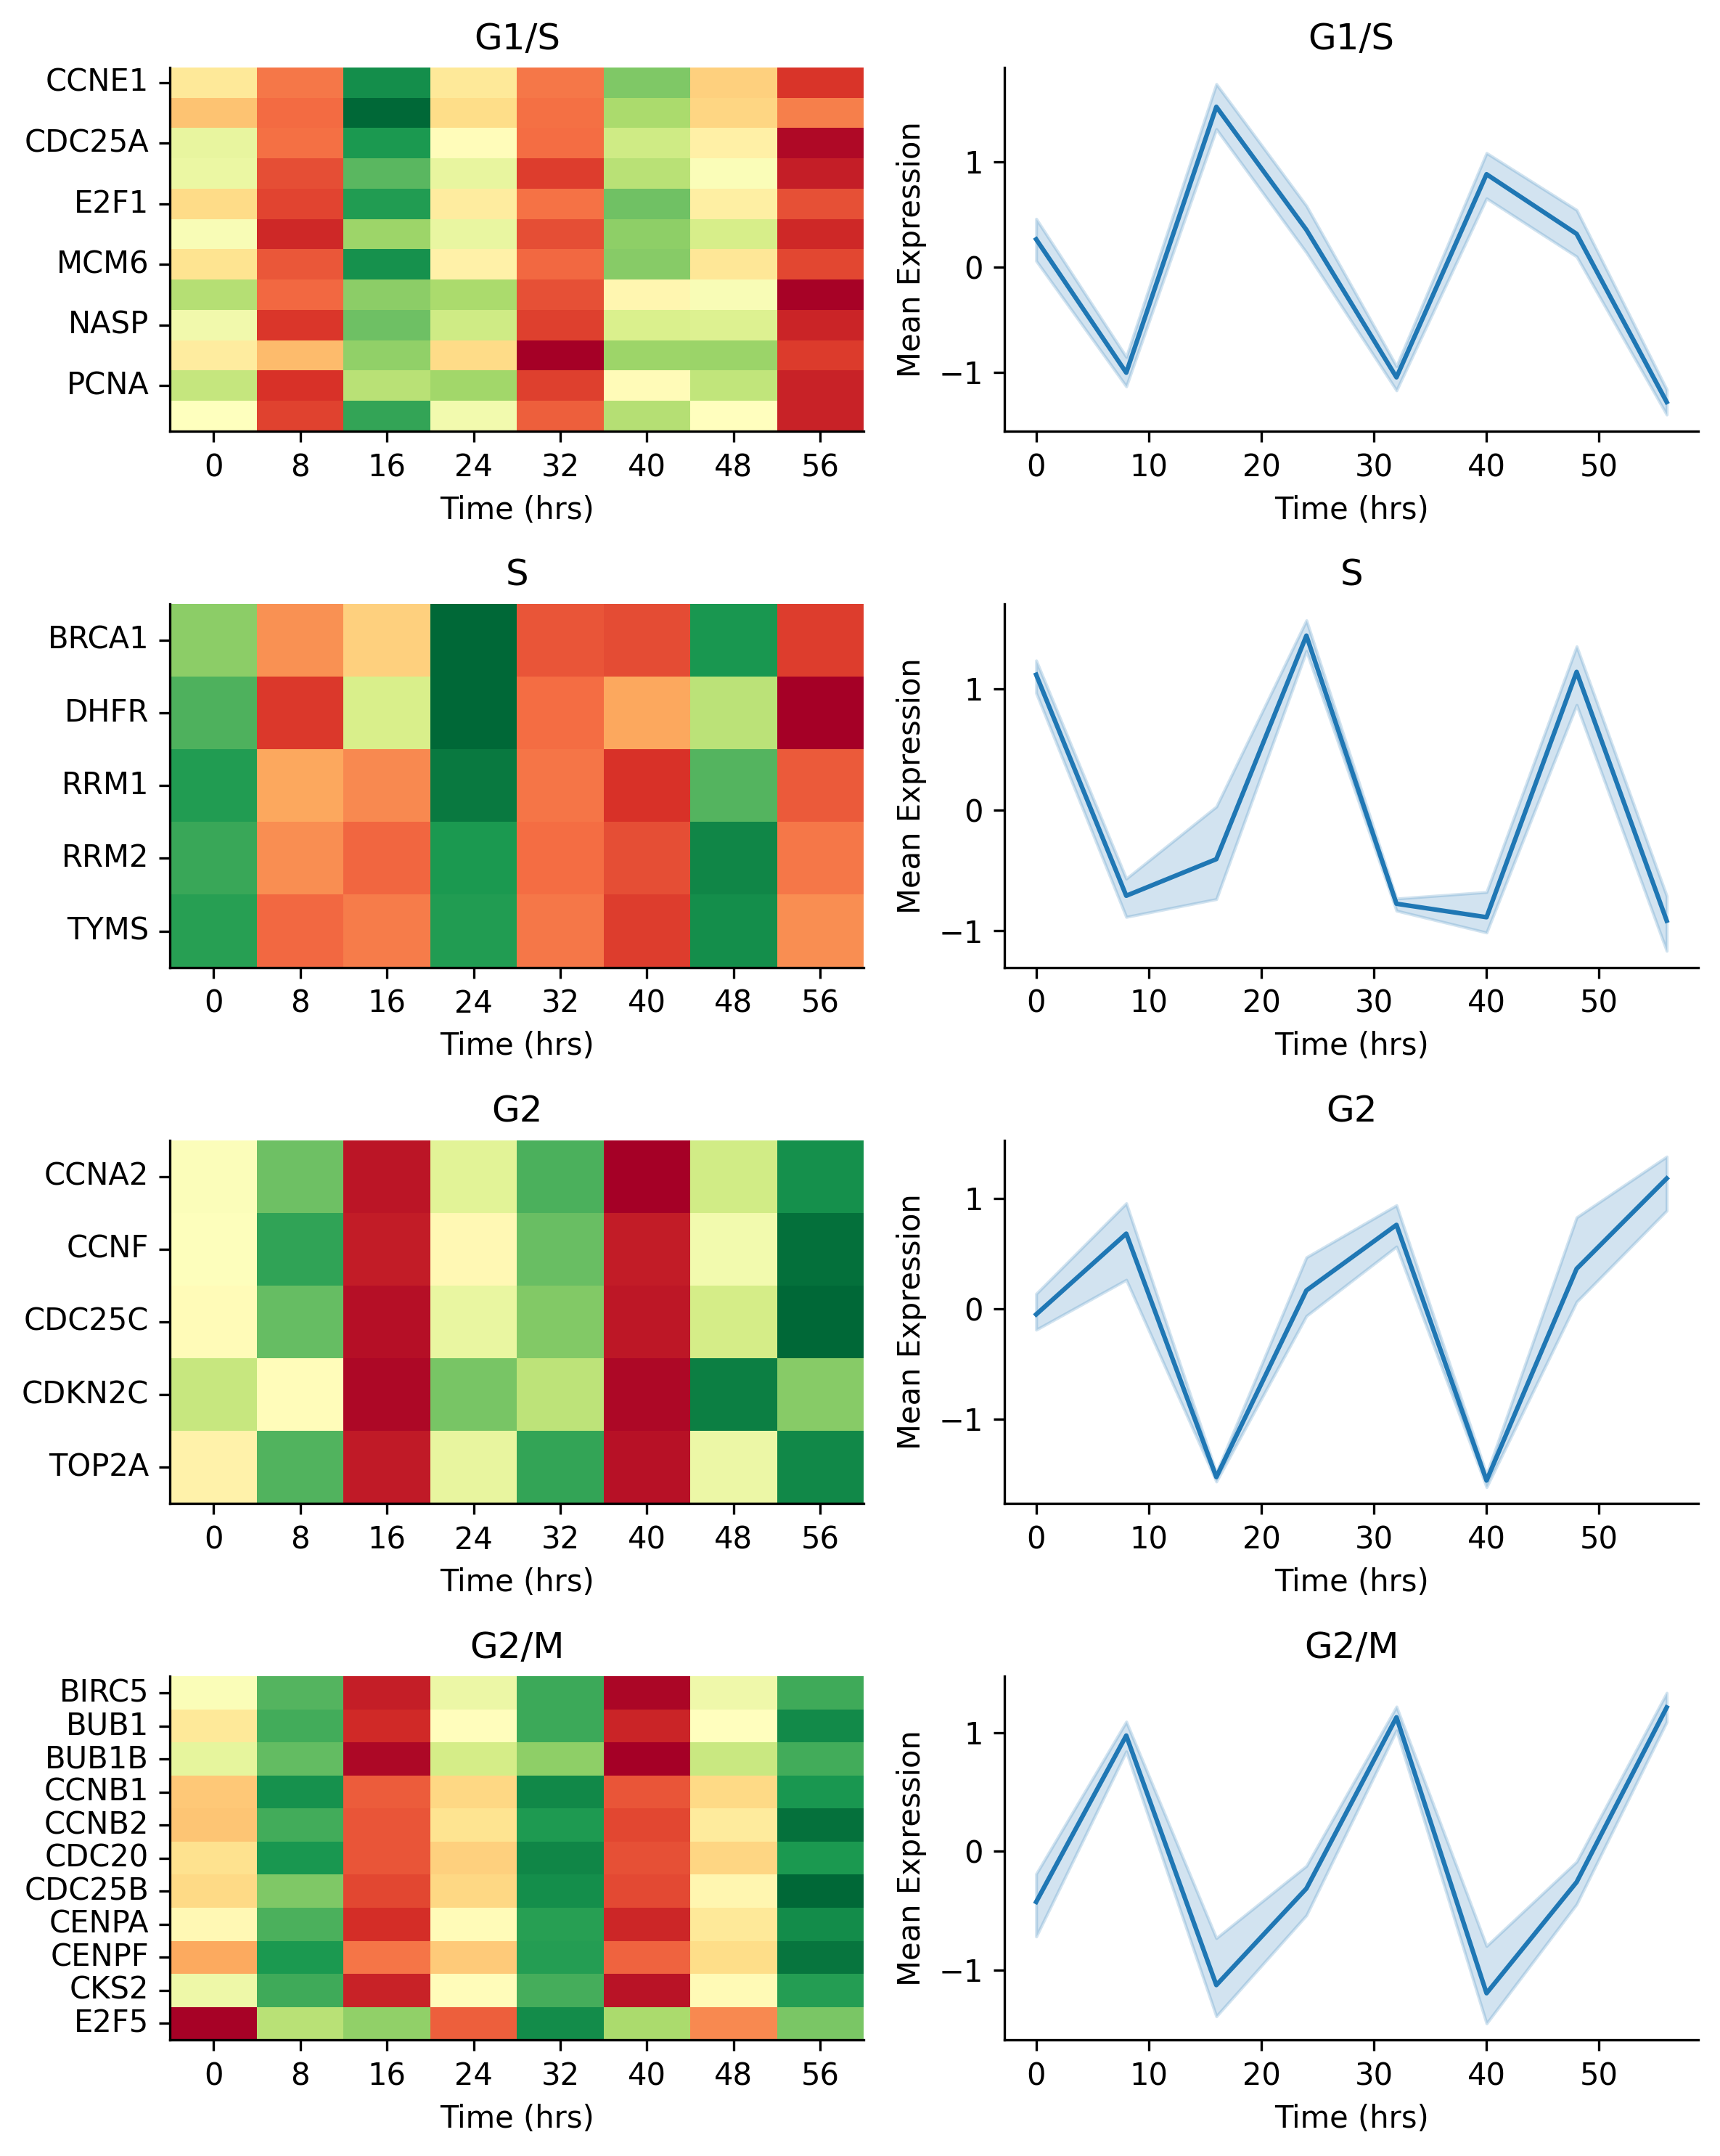

In [22]:
""" get a genes """

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 10
fig, axs = plt.subplots(4, 2)


for i, phase in enumerate(['G1/S', 'S', 'G2', 'G2/M']):
    group = T[T['phase'] == phase]
    phase_genes = [x.upper() for x in group['Gene symbol'].unique()]

    # filter normalized expression
    pdf = ddf[ddf['geneName'].isin(phase_genes) & (ddf['control'] == 'timecourse')]

    mat = pd.pivot_table(pdf, 
                         index=['geneName'],
                         columns='hours',
                         values='value')

    scaler = StandardScaler()
    mat_norm = scaler.fit_transform(mat.T).T
    mat_norm = pd.DataFrame(mat_norm, 
                            index=mat.index, 
                            columns=mat.columns)

    sns.heatmap(mat_norm, 
                ax=axs[i, 0],
                cbar=False,
                cmap='RdYlGn')

    axs[i, 0].set_ylabel("")
    axs[i, 0].set_title(phase)
    axs[i, 0].set_xlabel("Time (hrs)")

    
    m = pd.melt(mat_norm)

    sns.lineplot(data=m,
                 x='hours',
                 y='value',
                 ax=axs[i, 1])

    axs[i, 1].set_ylabel("Mean Expression")
    axs[i, 1].set_title(phase)
    axs[i, 1].set_xlabel("Time (hrs)")


sns.despine()
plt.tight_layout()

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [15]:
s = [
    'MCM5','PCNA','TYMS','FEN1','MCM7','MCM4',
    'RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1',
    'UHRF1','CENPU','HELLS','RFC2','POLR1B','NASP',
    'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7',
    'POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45',
    'CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
    'USP1','CLSPN','POLA1','CHAF1B','MRPL36','E2F8'
]

g2 = [
    'HMGB2','CDK1','NUSAP1','UBE2C','BIRC5',
    'TPX2','TOP2A','NDC80','CKS2','NUF2',
    'CKS1B','MKI67','TMPO','CENPF','TACC3',
    'PIMREG','SMC4','CCNB2','CKAP2L','CKAP2',
    'AURKB','BUB1','KIF11','ANP32E','TUBB4B',
    'GTSE1','KIF20B','HJURP','CDCA3','JPT1',
    'CDC20','TTK','CDC25C','KIF2C','RANGAP1',
    'NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2',
    'KIF23','HMMR','AURKA','PSRC1','ANLN',
    'LBR','CKAP5','CENPE','CTCF','NEK2',
    'G2E3','GAS2L3','CBX5','CENPA'
]

print(f"{len(s)=} {len(g2)=}")

len(s)=43 len(g2)=54


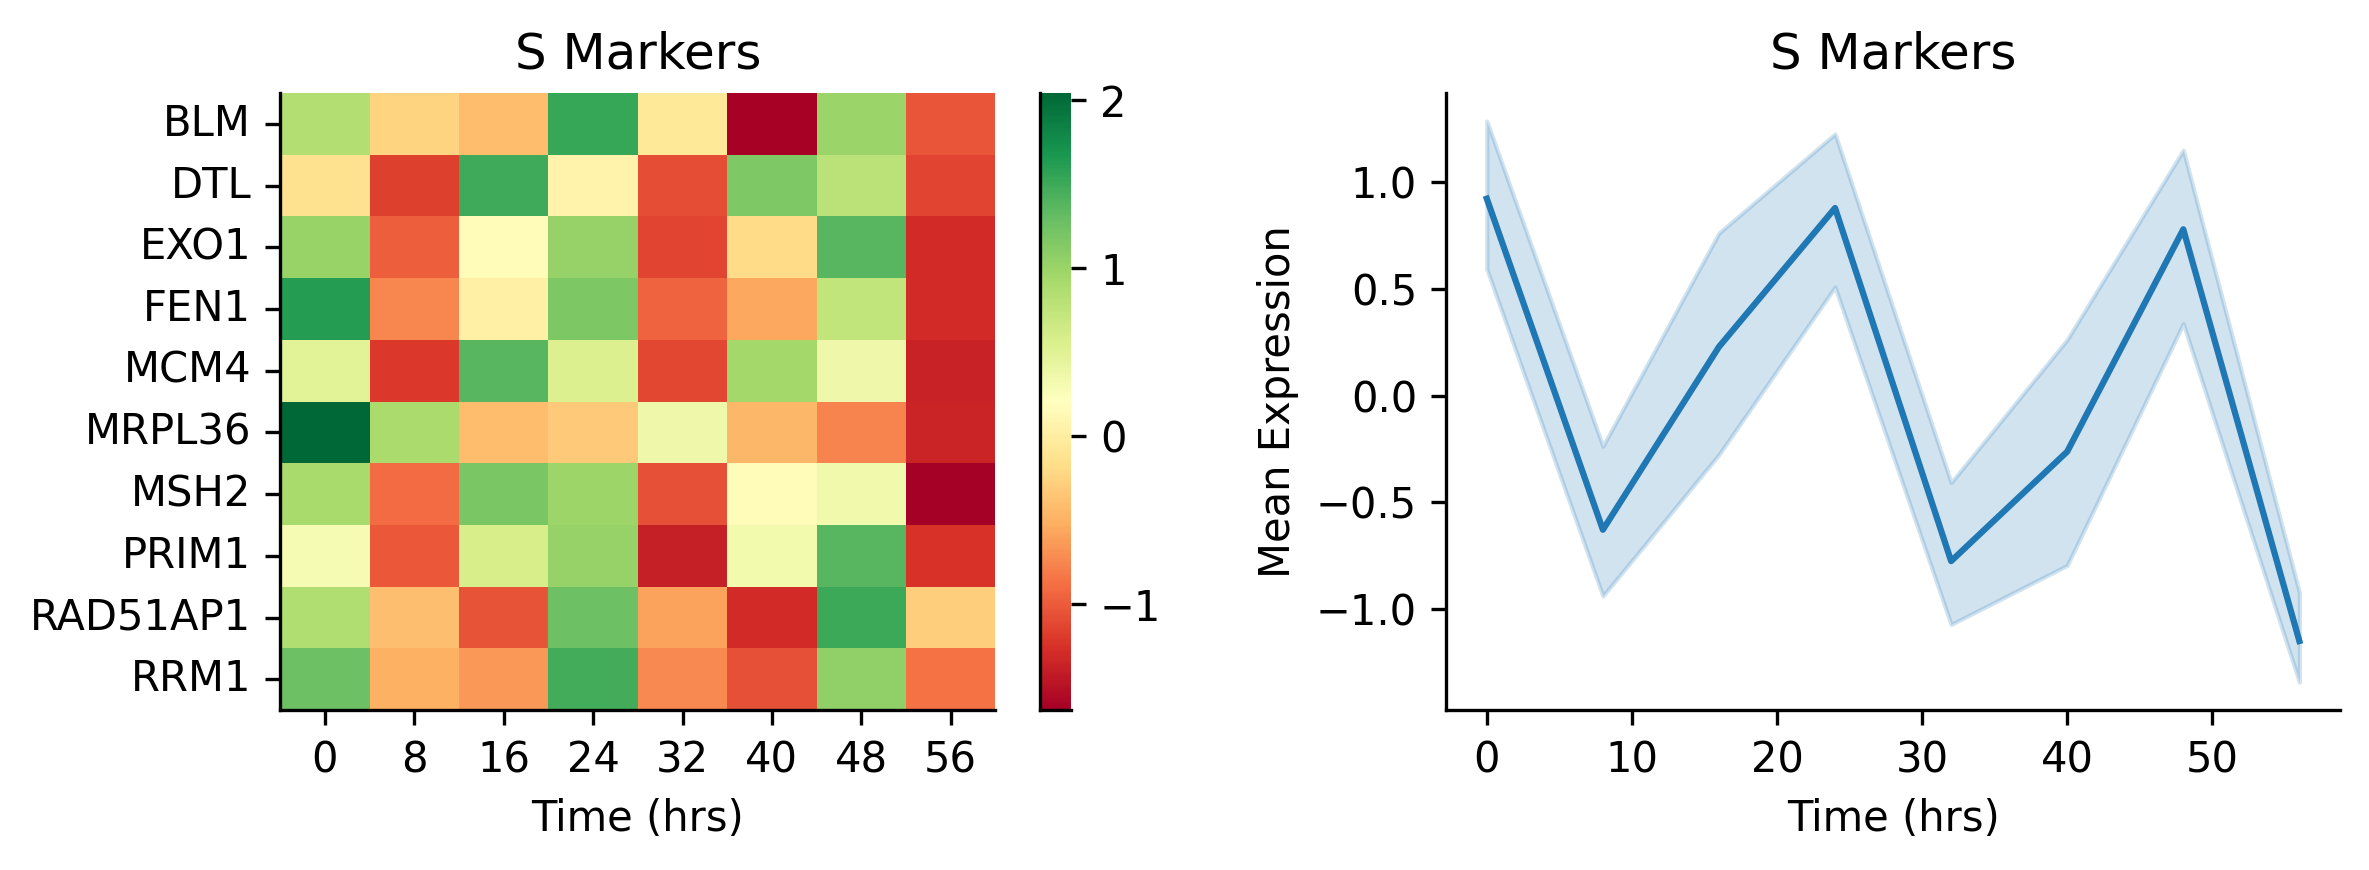

In [40]:
sample = 10
phase_genes = s
phase_genes = np.random.choice(phase_genes, sample, replace=False)

pdf = ddf[ddf['geneName'].isin(phase_genes) & (ddf['control'] == 'timecourse')]

mat = pd.pivot_table(pdf, 
                     index=['geneName'],
                     columns='hours',
                     values='value')

scaler = StandardScaler()
mat_norm = scaler.fit_transform(mat.T).T
mat_norm = pd.DataFrame(mat_norm, 
                        index=mat.index, 
                        columns=mat.columns)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 3

fig, axs = plt.subplots(1, 2)

sns.heatmap(mat_norm, 
            ax=axs[0],
            # cbar=False,
            cmap='RdYlGn')

axs[0].set_ylabel("")
axs[0].set_title("S Markers")
axs[0].set_xlabel("Time (hrs)")

m = pd.melt(mat_norm)

sns.lineplot(data=m,
             x='hours',
             y='value',
             ax=axs[1])

axs[1].set_ylabel("Mean Expression")
axs[1].set_title("S Markers")
axs[1].set_xlabel("Time (hrs)")

sns.despine()
plt.tight_layout()


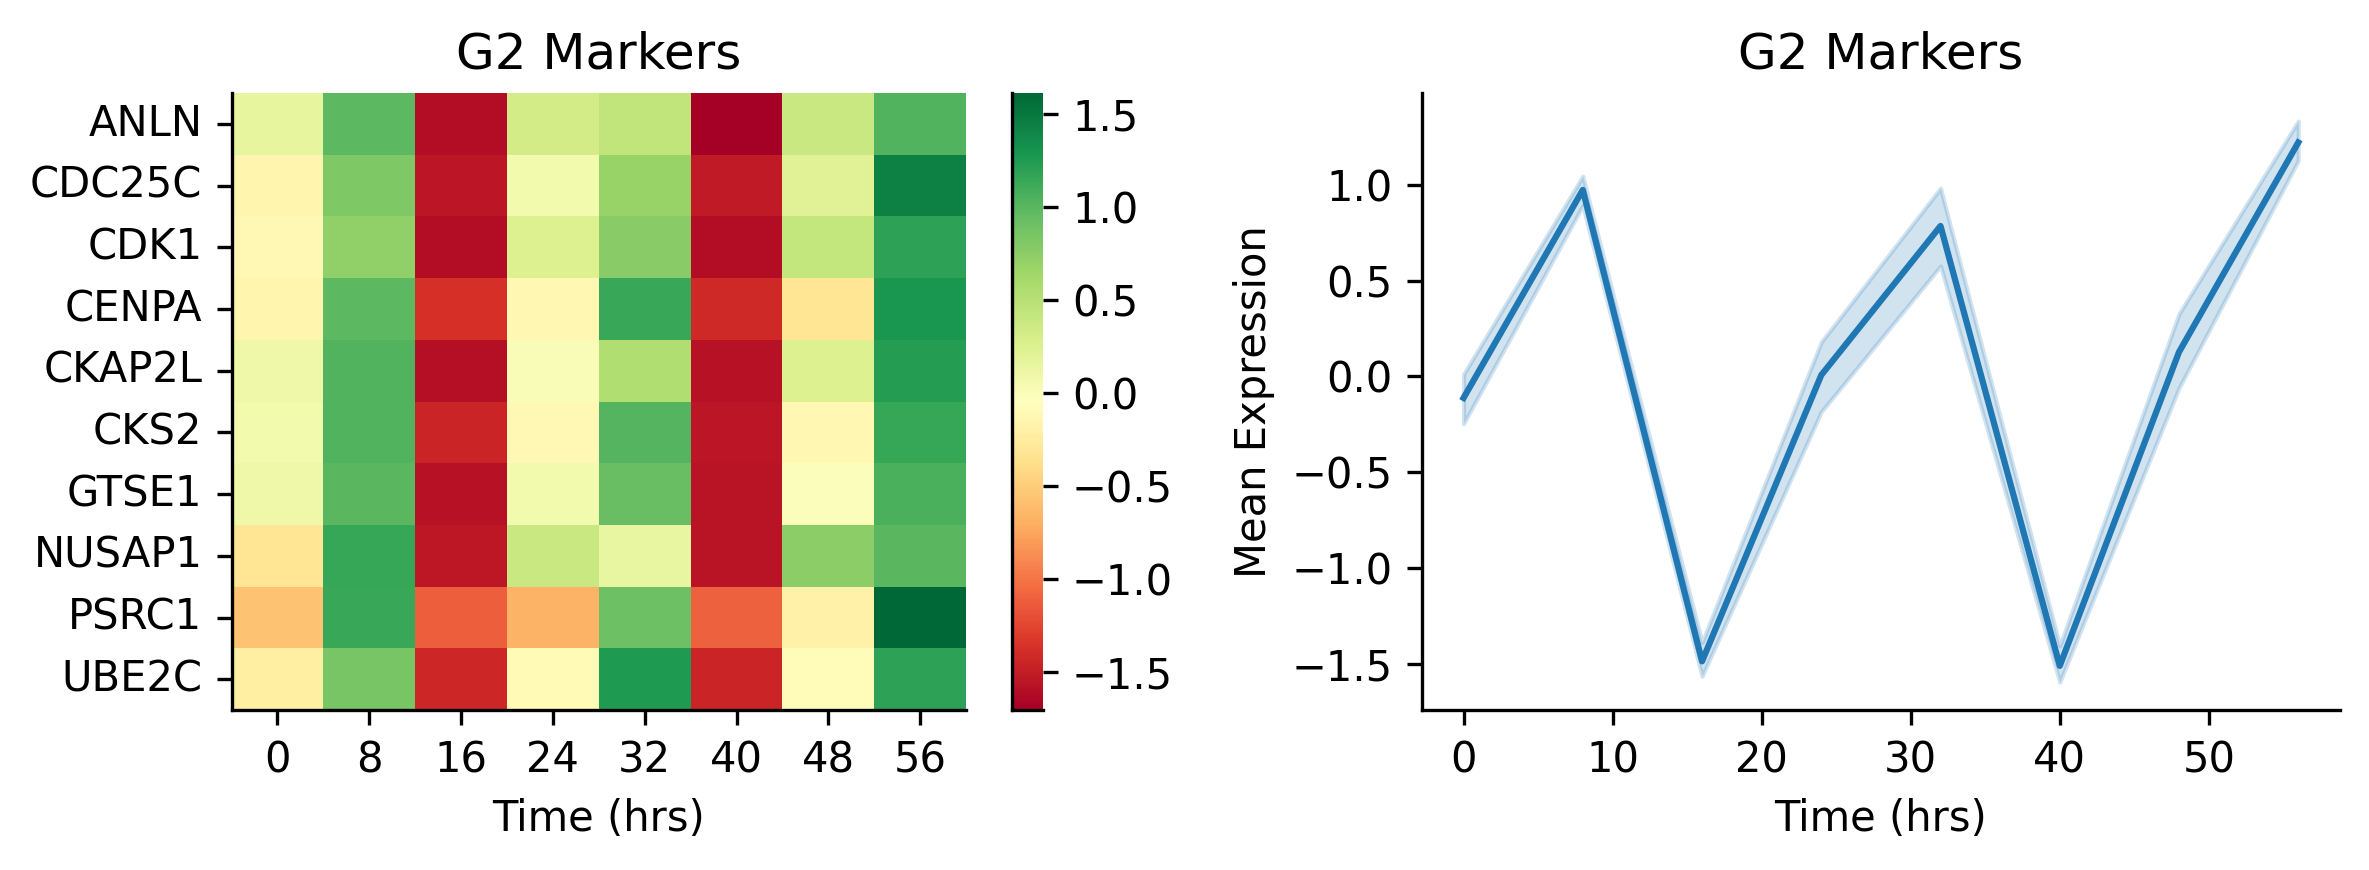

In [39]:
sample = 10
phase_genes = g2
phase_genes = np.random.choice(phase_genes, sample, replace=False)

pdf = ddf[ddf['geneName'].isin(phase_genes) & (ddf['control'] == 'timecourse')]

mat = pd.pivot_table(pdf, 
                     index=['geneName'],
                     columns='hours',
                     values='value')

scaler = StandardScaler()
mat_norm = scaler.fit_transform(mat.T).T
mat_norm = pd.DataFrame(mat_norm, 
                        index=mat.index, 
                        columns=mat.columns)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 3

fig, axs = plt.subplots(1, 2)

sns.heatmap(mat_norm, 
            ax=axs[0],
            # cbar=False,
            cmap='RdYlGn')

axs[0].set_ylabel("")
axs[0].set_title("G2 Markers")
axs[0].set_xlabel("Time (hrs)")

m = pd.melt(mat_norm)

sns.lineplot(data=m,
             x='hours',
             y='value',
             ax=axs[1])

axs[1].set_ylabel("Mean Expression")
axs[1].set_title("G2 Markers")
axs[1].set_xlabel("Time (hrs)")

sns.despine()
plt.tight_layout()
